# Modeling #1 - ARIMA

### Steps
- Caricamento dataset
- Train-test split
- Test di Dickey-Fuller e Differenziazione
- Verifica Autocorrelazione
- Training e previsione

In [2]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import tqdm
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

### Data Import

In [3]:
timesteps = np.load('../Data/timesteps.npy')
print(timesteps.shape)

(1000, 1, 300, 300)


In [4]:
# Rimozione valori soglia
timesteps[timesteps >= 1e5] = 0

In [5]:
# Seleziono solo i primi 800 frames (allagamento e stabilizzazione fluido)
timesteps = timesteps[:800]

### Analisi serie temporale con ARIMA
Si analizza il problema con l'applicazione dell'algoritmo ARIMA (Auto Regressive Integrated Moving Average). Questa tecnica statistica si applica su una serie temporale univariata, a patto che sia stazionaria.

In [6]:
sums = [np.mean(t) for t in timesteps]
sums_df = pd.DataFrame(
    data = sums,
    columns = ["value"]
)

In [7]:
np.max(timesteps)

0.131551

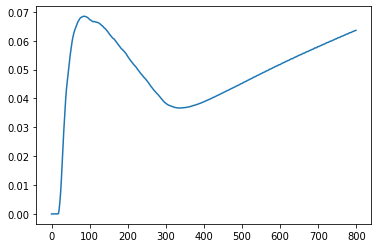

In [8]:
# Semplifico ogni matrice temporale con un solo numero (somma di tutte le celle)
plt.plot(sums_df)
pass

#### Test di Dicky-Fuller
Bisogna verificare se la serie temporale é stazionaria

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_check(data, verbose = True):
    result = adfuller(data)
    if verbose: print("Augmented Dicky-Fuller Test")
    labels = ["ADF Test Statistic", "p-value", "# of lags", "# observations used"]
    
    for value,label in zip(result, labels):
        if verbose: print("{}: {}".format(label, value))
        
    if result[1] <= 0.05:
        if verbose: print("Strong evidence against null hypothesis")
        if verbose: print("No unit root, data is stationary")
        return True
    # > 0.05
    else:
        if verbose: print("Weak evidence against null hypothesis")
        if verbose: print("There is root unit, data non stationary")
        return False

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
adf_check(sums_df["value"])

Augmented Dicky-Fuller Test
ADF Test Statistic: -2.1590425417885593
p-value: 0.22144489146757923
# of lags: 21
# observations used: 778
Weak evidence against null hypothesis
There is root unit, data non stationary


False

#### Differenziazione K
Un metodo per rendere la serie stazionaria (mean e std fissi nel tempo) é differenziare per K iterazioni: si sottraggono ad ogni valore della serie i suoi K precedenti.

Stationarity reached with k = 1


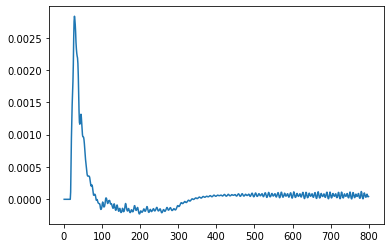

In [11]:
# curr - previous
diff = sums_df
k = 10

# Early stopping se raggiungo giá una serie stazionaria
for i in range(k):

  result = adf_check(diff["value"].dropna(), False)
  
  if result is True:
    print("Stationarity reached with k = {}".format(i))
    break

  diff["value"] = sums_df["value"] - sums_df["value"].shift(1)

diff["value"].plot()

#### Autocorrelation
L'autocorrelazione puó essere d'aiuto per capire se applicare un modello piú basato sull'Auto Regressione o sul Moving Average.

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

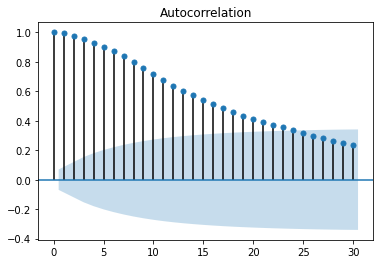

In [18]:
fig_first = plot_acf(diff['value'].dropna())

#### ARIMA

In [15]:
# Suppress framework warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [16]:
from statsmodels.tsa.arima_model import ARIMA

In [20]:
train_size = int(sums_df["value"].dropna().shape[0] * 0.9)
train = sums_df["value"].dropna()[0:train_size]
test = np.asarray(sums_df["value"].dropna()[train_size:])

# Train
avg_err = []

error = []

history = [v for v in train]
predicted = [v for v in train]

# Numero crescente nel futuro (test)
for t in range(len(test)):

  # fornire i valori P, D, Q
  # p = quanti lags per superare la linea di significato del partial correlation plot?
  # d = ordine di differenziazione
  # q = di quanti termini effettuare Moving Average per ridurre l'errore di lagged forecast
  p = 2
  d = 1
  q = 0
  model = ARIMA(history, order=(2, 1, 0))
  model = model.fit()

  y_hat = model.forecast()[0]
  y = test[t]

  history.append(y)
  predicted.append(y_hat)

  # (Differenza / true) = % errore
  error.append(abs((y_hat - y)/y))

print("Error: {}%".format(round((np.mean(error)) * 100, 2)))
avg_err.append(round((np.mean(error)) * 100, 2))

Error: 25.72%


In [ ]:
# Test con w = 5 
train = sums_df["value"].dropna()[0:train_size]
history = [v for v in train]
predicted = [v for v in train]

for t in range(len(test)):
  model = ARIMA(history, order=(2, 1, 0))
  model = model.fit()

  y_hat = model.forecast()[0]
  y = test[t]

  history.append(y)
  predicted.append(y_hat)

  # (Differenza / true) = % errore
  err = abs((y_hat - y)/y)
  print("{}".format(err))
  

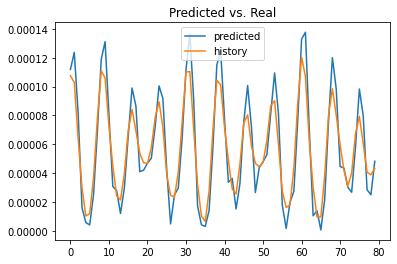

In [30]:
plt.title("Predicted vs. Real")
plt.plot(predicted[train_size:], label="predicted")
plt.plot(history[train_size:], label="history")
plt.legend()